In [1]:
from tqdm import tqdm
import sys
import datetime

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from linearmodels import IV2SLS, IVLIML, IVGMM, IVGMMCUE
from linearmodels import PanelOLS

# features

In [583]:
trains = pd.concat(
    [
        pd.read_pickle(
            "/Users/vigadam/Documents/github/renfe-analysis/data/MAD_BAR_all/MAD_BAR/MAD_BAR_trains.pkl"
        ),
        pd.read_pickle(
            "/Users/vigadam/Documents/github/renfe-analysis/data/MAD_BAR_all/BAR_MAD/BAR_MAD_trains.pkl"
        ),
    ]
)

<AxesSubplot:>

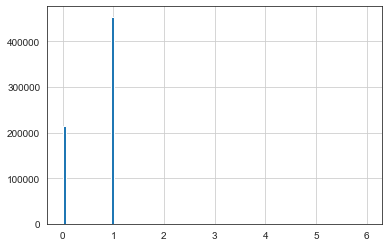

In [554]:
(trains["Turista_Promo_price"] - (trains["Turista_Promo +_price"] - 6)).round().hist(bins=100)

In [584]:
data = (
    trains.groupby(["train_id", "days_till_dep"])
    .agg(
        mean_econ_price=("Turista_Promo +_price", np.nanmean),
        mean_first_price=("Preferente_Promo +_price", np.nanmean),
        max_econ_seats=("Turista_Promo +_seats", max),
        min_econ_seats=("Turista_Promo +_seats", min),
        mean_econ_seats=("Turista_Promo +_seats", "mean"),
        max_first_seats=("Preferente_Promo +_seats", max),
        min_first_seats=("Preferente_Promo +_seats", min),
        mean_first_seats=("Preferente_Promo +_seats", "mean"),
        departure=("departure", "first"),
        duration=("duration", "first"),
    )
    .reset_index()
)

In [585]:
data["econ_seats_sold"] = (data["max_econ_seats"] - data["min_econ_seats"]).round()
data["first_seats_sold"] = (data["max_first_seats"] - data["min_first_seats"]).round()

In [586]:
data["weekday"] = data["departure"].apply(
    lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").weekday()
)
data["depart_month"] = data["departure"].apply(
    lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month
)
data["depart_hour"] = data["departure"].apply(
    lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").hour
)
# only jan, feb, march
data = data.loc[data["depart_month"] < 4].reset_index(drop=True)

In [587]:
data["day_part"] = data["depart_hour"] > 12
data["ln_price"] = np.log(data["mean_econ_price"] + 1)
data["ln_econ_seat"] = np.log(data["econ_seats_sold"] + 1)
data["const"] = 1

In [588]:
#filter for seats sold on an individual day is less than 100
data = data.loc[data["econ_seats_sold"] < 100].reset_index(drop=True)

In [589]:
# filter for those trains, that data is available for more than 15 days
id_obs = data.groupby("train_id")["days_till_dep"].count().reset_index()
train_ids = list(id_obs.loc[id_obs["days_till_dep"] > 15]["train_id"].values)

data = data.loc[data["train_id"].isin(train_ids)].reset_index(drop=True)

In [590]:
# filter for trains, whos data is close to departure day by min(days until departure) < 3)

min_days_until_dep = data.groupby("train_id")["days_till_dep"].min().reset_index()
data = data.loc[
    data["train_id"].isin(
        list(
            min_days_until_dep.loc[min_days_until_dep["days_till_dep"] < 3]["train_id"]
        )
    )
]

In [591]:
data["price_change"] = (
    data.sort_values(by=["train_id", "days_till_dep"], ascending=False)
    .groupby("train_id")["mean_econ_price"]
    .transform("diff")
)

data["price_change_percentage"] = (data["price_change"] / data["mean_econ_price"]).round(3)

data["price_change_direction"] = np.where(
    data["price_change_percentage"] > 0,
    1,
    np.where(data["price_change_percentage"] < 0, -1, 0),
)

In [592]:
# filter if price drop is greater than 0.5
data = data.loc[data["price_change_percentage"]>-0.9].reset_index(drop=True)

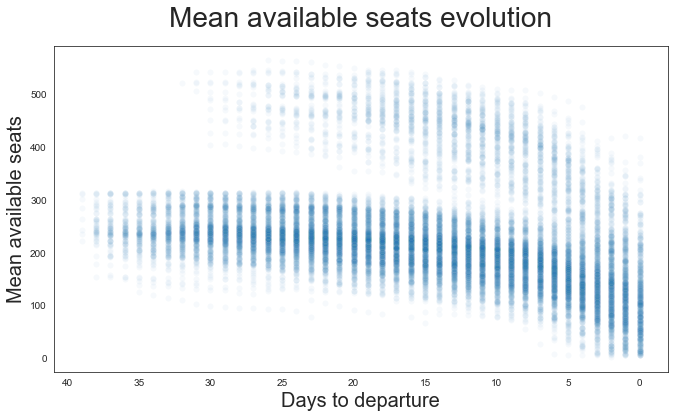

In [593]:
train_ids = (
    data.groupby("train_id")["price_change"]
    .max()
    .reset_index()
    .sort_values(by=["price_change"])
    .reset_index(drop=True)
    .loc[:, "train_id"]
    .values
)
plt.figure(figsize=(11, 6))

sns.scatterplot(
    data=data.loc[data["train_id"].isin(train_ids)],
    x="days_till_dep",
    y="mean_econ_seats",
    estimator="mean",
    alpha=0.04
)

plt.gca().invert_xaxis()

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Mean available seats", fontsize=20, fontweight=450)

plt.title("Mean available seats evolution", fontsize=28, y=1.04)

plt.savefig("figures/available_seats_evolution", dpi=300)
plt.show()

In [594]:
# differentiate big and small trains, work with small
max_seats = data.groupby("train_id")["mean_econ_seats"].max().reset_index()


data_small =data.loc[
    data["train_id"].isin(
        list(max_seats.loc[max_seats["mean_econ_seats"] < 330]["train_id"])
    )
]

data_big =data.loc[
    data["train_id"].isin(
        list(max_seats.loc[max_seats["mean_econ_seats"] > 350]["train_id"])
    )
]

In [595]:
data = data_small

In [596]:
len(data["train_id"].unique())

558

In [597]:
price_changed = data.groupby("train_id")["price_change"].sum().reset_index().round(2)
price_changed["price_change"].value_counts()

 0.00     121
 18.55     28
 9.80      22
 8.75      19
 27.25     16
         ... 
-12.71      1
-18.53      1
 8.57       1
 14.51      1
 6.81       1
Name: price_change, Length: 200, dtype: int64

In [598]:
data["price_change_direction"] = np.where(
    data["price_change_percentage"] > 0,
    1,
    np.where(data["price_change_percentage"] < 0, -1, 0),
)
data["price_increase"] = np.where(data["price_change_percentage"] > 0, 1, 0)

In [599]:
data["seats_sold_prev_day"] = data.sort_values(by=["train_id", "days_till_dep"])[
    "econ_seats_sold"
].shift(-2)

data["sales_prev_day"] = data["seats_sold_prev_day"] > 0

In [600]:
data["max_seat_capacity"] = 313

data["capacity"] = data["mean_econ_seats"]/data["max_seat_capacity"]

data["loading_factor"] = (
    (data["max_seat_capacity"] - data["mean_econ_seats"]) / data["max_seat_capacity"]
).round(2)

data["loading_factor_round"] = (
    (data["max_seat_capacity"] - data["mean_econ_seats"]) / data["max_seat_capacity"]
).round(1)

data["loading_factor_cat"] = np.where(
    data["loading_factor"] > data["loading_factor"].mean(), "high", "low"
)

In [601]:
data.to_pickle("/Users/vigadam/Documents/github/renfe-analysis/data/MAD_BAR_small_trains_features.pkl")

___

## Figures

In [602]:
data = pd.read_pickle("/Users/vigadam/Documents/github/renfe-analysis/data/MAD_BAR_small_trains_features.pkl")

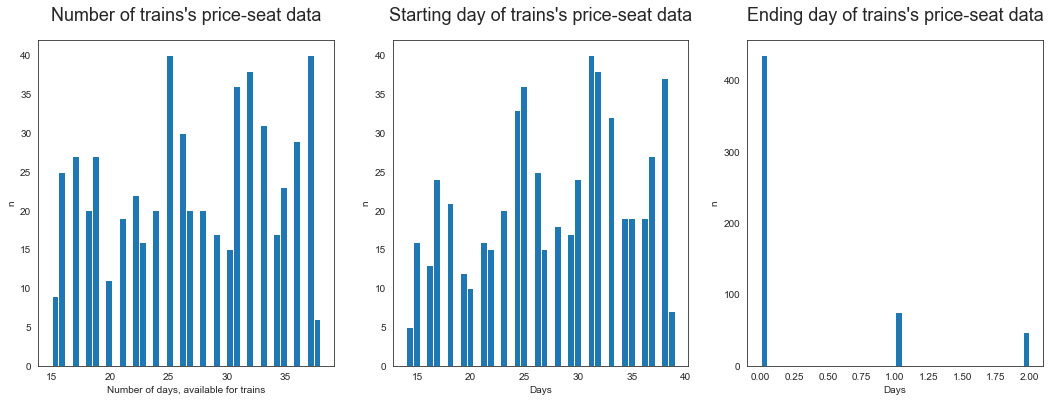

In [574]:
figdata = data.sort_values(by=["train_id", "days_till_dep"]).groupby("train_id")[
    "days_till_dep"
]

plt.figure(figsize=(18, 6))

ax1 = plt.subplot(1, 3, 1)
#ax1.set_xlim(13, 35)
# ax1.set_ylim(0,50)
ax1.hist(figdata.count(), bins=40)
plt.xlabel("Number of days, available for trains", fontsize=10, fontweight=450)
plt.ylabel("n", fontsize=10, fontweight=450)

plt.title("Number of trains's price-seat data", fontsize=18, y=1.04)


ax2 = plt.subplot(1, 3, 2)
# ax2.set_xlim(35, 110)
# ax2.set_ylim(0, 0.14)
ax2.hist(figdata.last(), bins=40)
plt.xlabel("Days", fontsize=10, fontweight=450)
plt.ylabel("n", fontsize=10, fontweight=450)

plt.title(
    "Starting day of trains's price-seat data", fontsize=18, y=1.04
)


ax3 = plt.subplot(1, 3, 3)
# ax3.set_xlim(35, 110)
# ax3.set_ylim(0, 0.14)
ax3.hist(figdata.first(), bins=40)
plt.xlabel("Days", fontsize=10, fontweight=450)
plt.ylabel("n", fontsize=10, fontweight=450)

plt.title(
    "Ending day of trains's price-seat data", fontsize=18, y=1.04
)

plt.savefig("figures/days_plots", dpi=300)

plt.show()

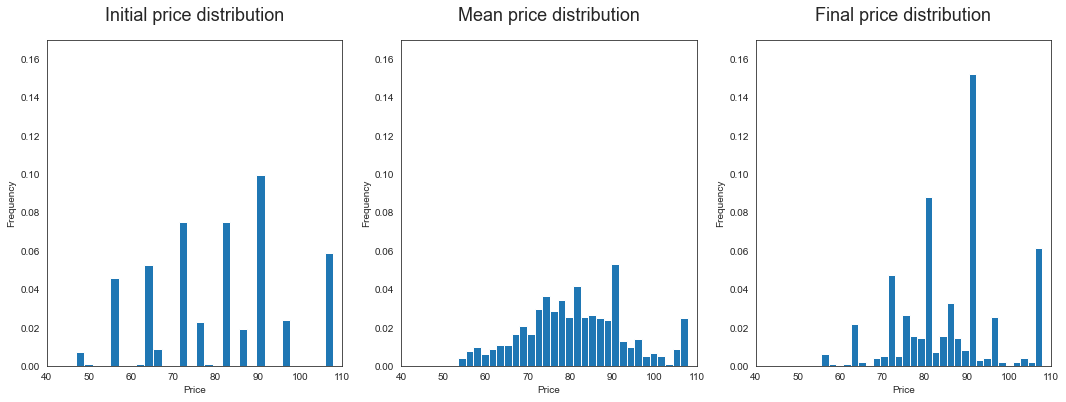

In [575]:
figdata = data.sort_values(by=["train_id", "days_till_dep"]).groupby("train_id")[
    "mean_econ_price"
]

plt.figure(figsize=(18, 6))

xlim_min = 40
xlim_max = 110
ylim_min = 0
ylim_max = 0.17

ax1 = plt.subplot(1, 3, 1)
ax1.set_xlim(xlim_min, xlim_max)
ax1.set_ylim(ylim_min, ylim_max)
ax1.hist(figdata.last(), bins=30, density=True)
plt.xlabel("Price", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Initial price distribution", fontsize=18, y=1.04)


ax2 = plt.subplot(1, 3, 2)
ax2.set_xlim(xlim_min, xlim_max)
ax2.set_ylim(ylim_min, ylim_max)
ax2.hist(figdata.mean(), bins=30, density=True)
plt.xlabel("Price", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Mean price distribution", fontsize=18, y=1.04)


ax3 = plt.subplot(1, 3, 3)
ax3.set_xlim(xlim_min, xlim_max)
ax3.set_ylim(ylim_min, ylim_max)
ax3.hist(figdata.first(), bins=30, density=True)
plt.xlabel("Price", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Final price distribution", fontsize=18, y=1.04)

plt.savefig("figures/price_distributions", dpi=300)

plt.show()

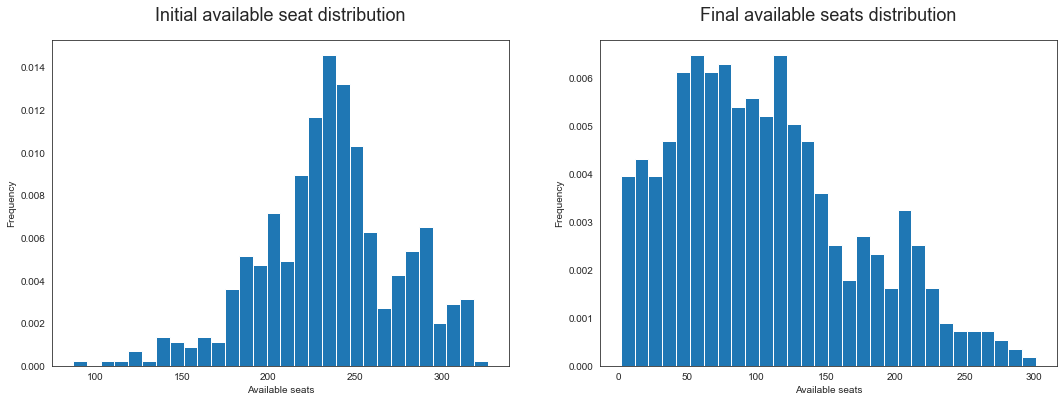

In [576]:
figdata = data.sort_values(by=["train_id", "days_till_dep"]).groupby("train_id")[
    "mean_econ_seats"
]

plt.figure(figsize=(18, 6))

ax1 = plt.subplot(1, 2, 1)
#ax1.set_xlim(35, 110)
#ax1.set_ylim(0, 0.14)
ax1.hist(figdata.last(), bins=30, density=True)
plt.xlabel("Available seats", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Initial available seat distribution", fontsize=18, y=1.04)


ax3 = plt.subplot(1, 2, 2)
#ax3.set_xlim(35, 110)
#ax3.set_ylim(0, 0.14)
ax3.hist(figdata.first(), bins=30, density=True)
plt.xlabel("Available seats", fontsize=10, fontweight=450)
plt.ylabel("Frequency", fontsize=10, fontweight=450)

plt.title("Final available seats distribution", fontsize=18, y=1.04)

plt.savefig("figures/price_distributions", dpi=300)

plt.show()

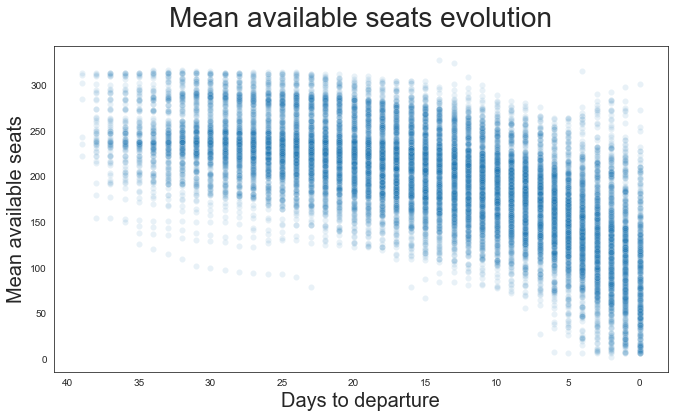

In [577]:
train_ids = (
    data.groupby("train_id")["price_change"]
    .max()
    .reset_index()
    .sort_values(by=["price_change"])
    .reset_index(drop=True)
    .loc[:, "train_id"]
    .values
)
plt.figure(figsize=(11, 6))

sns.scatterplot(
    data=data.loc[data["train_id"].isin(train_ids)],
    x="days_till_dep",
    y="mean_econ_seats",
    alpha=0.1
    #hue="train_id",
)#.get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Mean available seats", fontsize=20, fontweight=450)

plt.title("Mean available seats evolution", fontsize=28, y=1.04)

plt.savefig("figures/available_seats_evolution", dpi=300)
plt.show()

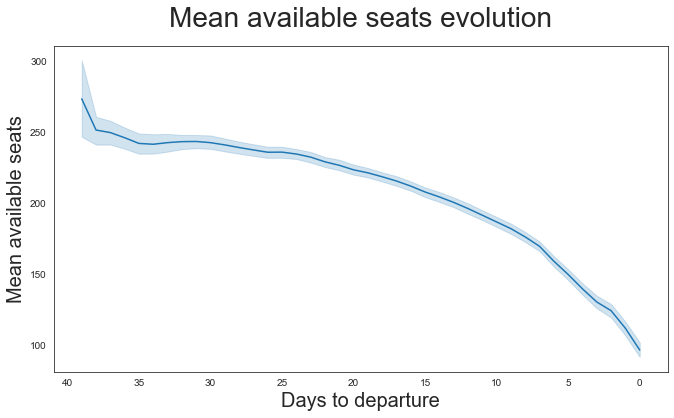

In [578]:
train_ids = (
    data.groupby("train_id")["price_change"]
    .max()
    .reset_index()
    .sort_values(by=["price_change"])
    .reset_index(drop=True)
    .loc[:, "train_id"]
    .values
)
plt.figure(figsize=(11, 6))

sns.lineplot(
    data=data.loc[data["train_id"].isin(train_ids)],
    x="days_till_dep",
    y="mean_econ_seats",
    estimator="mean",
    #hue="train_id",
)#.get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Mean available seats", fontsize=20, fontweight=450)

plt.title("Mean available seats evolution", fontsize=28, y=1.04)

plt.savefig("figures/available_seats_evolution", dpi=300)
plt.show()

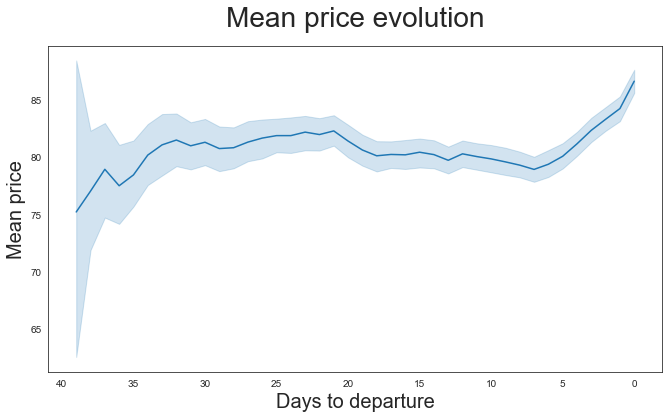

In [581]:
plt.figure(figsize=(11, 6))

sns.lineplot(
    data=data,
    x="days_till_dep",
    y="mean_econ_price",
    estimator="mean",
    #hue="train_id",
)#.get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Mean price", fontsize=20, fontweight=450)

#plt.xlim(35,0)
#plt.ylim(75,90)

plt.title("Mean price evolution", fontsize=28, y=1.04)

plt.savefig("figures/mean price evolution", dpi=300)
plt.show()

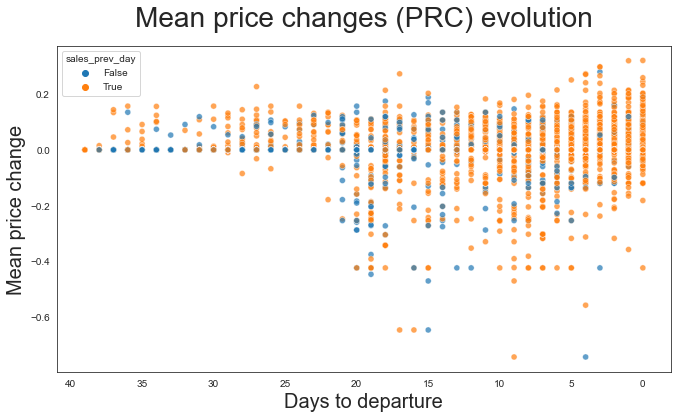

In [580]:
train_ids = (
    data.groupby("train_id")["price_change"]
    .max()
    .reset_index()
    .sort_values(by=["price_change"])
    .reset_index(drop=True)
    .loc[:, "train_id"]
    .values
)
plt.figure(figsize=(11, 6))

sns.scatterplot(
    data=data.loc[data["train_id"].isin(train_ids)],
    x="days_till_dep",
    y="price_change_percentage",
    estimator="mean",
    hue="sales_prev_day",
    alpha=0.7,
)  # .get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Mean price change", fontsize=20, fontweight=450)

plt.title("Mean price changes (PRC) evolution", fontsize=28, y=1.04)

plt.savefig("figures/mean price (PRC) changes", dpi=300)
plt.show()

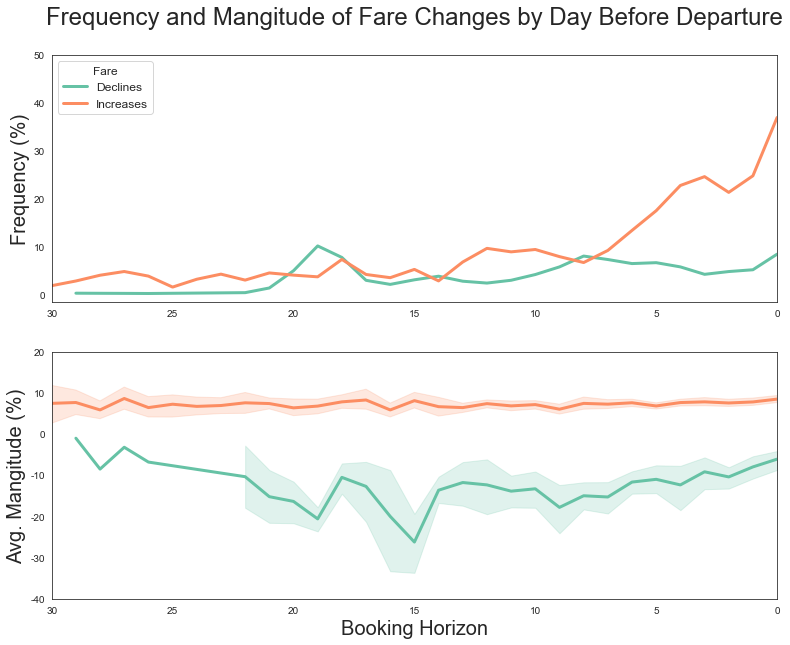

In [606]:
plt.figure(figsize=(13, 10))


figdata = (
    pd.DataFrame(data.groupby("days_till_dep")["price_change_direction"].value_counts())
    .rename(columns={"price_change_direction": "sum"})
    .reset_index()
)

figdata = figdata.merge(
    figdata.groupby("days_till_dep")["sum"]
    .sum()
    .reset_index()
    .rename(columns={"sum": "all"}),
    on="days_till_dep",
)

figdata["price_change_freq"] = figdata["sum"] / figdata["all"]

figdata = figdata.loc[figdata["price_change_direction"] != 0]

# TOP FIG.
ax1 = plt.subplot(2, 1, 1)

sns.lineplot(
    data=figdata,
    x="days_till_dep",
    y="price_change_freq",
    hue="price_change_direction",
    palette="Set2",
    linewidth=3,
    ax=ax1,
)

plt.gca().invert_xaxis()

plt.xlabel("", fontsize=0, fontweight=450)
plt.ylabel("Frequency (%)", fontsize=20, fontweight=450)
plt.title(
    "Frequency and Mangitude of Fare Changes by Day Before Departure",
    fontsize=24,
    y=1.1,
)


ax1.legend(("Declines", "Increases"), loc="upper left", prop={"size": 12}).set_title(
    "Fare", prop={"size": 12}
)

tick_max = 0.5
tick_interval = 0.1
ax1.set_yticks(np.arange(0, tick_max + tick_interval, tick_interval))
ax1.set_yticklabels(np.arange(0, 60, 10))
ax1.set_xlim(30, 0)


# BOTTOM FIG.
figdata_2 = data.loc[data["price_change_direction"] != 0]

ax2 = plt.subplot(2, 1, 2)
sns.lineplot(
    data=figdata_2,
    x="days_till_dep",
    y="price_change_percentage",
    estimator="mean",
    hue="price_change_direction",
    palette="Set2",
    linewidth=3,
    ax=ax2,
).get_legend().remove()

plt.gca().invert_xaxis()

plt.xlabel("Booking Horizon", fontsize=20, fontweight=450)
plt.ylabel("Avg. Mangitude (%)", fontsize=20, fontweight=450)


tick_max = 0.2
tick_min = -0.4
tick_interval = 0.1

ax2.set_yticks(np.arange(tick_min, tick_max + tick_interval, tick_interval))
ax2.set_yticklabels(
    np.arange(int(tick_min * 100), int(tick_max * 100 + 1), int(tick_interval * 100))
)
ax2.set_xlim(30, 0)


plt.savefig("figures/freq_and_magn_of_fare_changes", dpi=300)
plt.show()

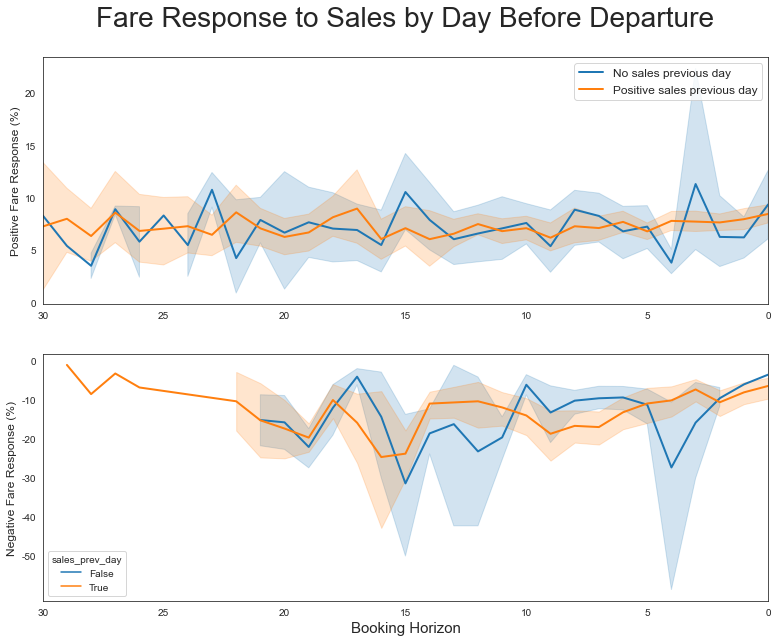

In [607]:
plt.figure(figsize=(13, 10))


# TOP FIG
ax1 = plt.subplot(2, 1, 1)

figdata = data.loc[data["price_change_direction"] > 0]


sns.lineplot(
    data=figdata,
    x="days_till_dep",
    y="price_change_percentage",
    estimator="mean",
    hue="sales_prev_day",
    #ci=False,
    ax=ax1,
    linewidth=2,
)  # .get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("", fontsize=20, fontweight=450)
plt.ylabel("Positive Fare Response (%)", fontsize=12, fontweight=450)


ax1.legend(
    ("No sales previous day", "Positive sales previous day"),
    loc="upper right",
    prop={"size": 12},
)  # .set_title("", prop={"size": 0})


tick_max = 0.2
tick_min = 0
tick_interval = 0.05

ax1.set_yticks(np.arange(tick_min, tick_max + tick_interval, tick_interval))
ax1.set_yticklabels(
    np.arange(int(tick_min * 100), int(tick_max * 100 + 1), int(tick_interval * 100))
)
ax1.set_xlim(30, 0)

plt.title("Fare Response to Sales by Day Before Departure", fontsize=28, y=1.1)

# TOP
ax2 = plt.subplot(2, 1, 2)

figdata_2 = data.loc[data["price_change_direction"] < 0]


sns.lineplot(
    data=figdata_2,
    x="days_till_dep",
    y="price_change_percentage",
    estimator="mean",
    hue="sales_prev_day",
    #ci=False,
    ax=ax2,
    linewidth=2,
)#.get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("Booking Horizon", fontsize=15, fontweight=450)
plt.ylabel("Negative Fare Response (%)", fontsize=12, fontweight=450)


tick_max = 0
tick_min = -0.5
tick_interval = 0.1

ax2.set_yticks(np.arange(tick_min, tick_max + tick_interval, tick_interval))
ax2.set_yticklabels(
    np.arange(int(tick_min * 100), int(tick_max * 100 + 1), int(tick_interval * 100))
)
ax2.set_xlim(30, 0)

plt.title("", fontsize=0, y=1.04)

plt.savefig("figures/fare_response", dpi=300)
plt.show()

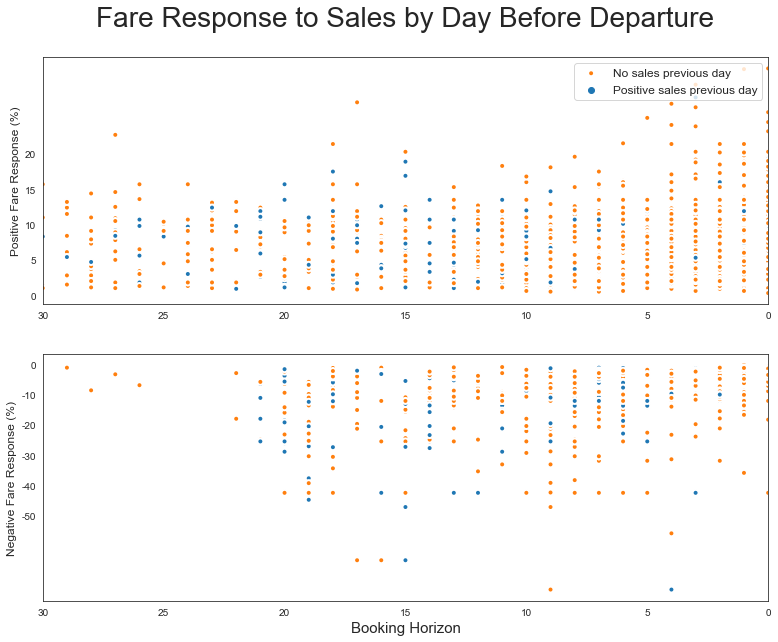

In [608]:
plt.figure(figsize=(13, 10))


# TOP FIG
ax1 = plt.subplot(2, 1, 1)

figdata = data.loc[data["price_change_direction"] > 0]


sns.scatterplot(
    data=figdata,
    x="days_till_dep",
    y="price_change_percentage",
    estimator="mean",
    hue="sales_prev_day",
    ci=False,
    ax=ax1,
    linewidth=2,
)  # .get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("", fontsize=20, fontweight=450)
plt.ylabel("Positive Fare Response (%)", fontsize=12, fontweight=450)


ax1.legend(
    ("No sales previous day", "Positive sales previous day"),
    loc="upper right",
    prop={"size": 12},
)  # .set_title("", prop={"size": 0})


tick_max = 0.2
tick_min = 0
tick_interval = 0.05

ax1.set_yticks(np.arange(tick_min, tick_max + tick_interval, tick_interval))
ax1.set_yticklabels(
    np.arange(int(tick_min * 100), int(tick_max * 100 + 1), int(tick_interval * 100))
)
ax1.set_xlim(30, 0)

plt.title("Fare Response to Sales by Day Before Departure", fontsize=28, y=1.1)

# TOP
ax2 = plt.subplot(2, 1, 2)

figdata_2 = data.loc[data["price_change_direction"] < 0]


sns.scatterplot(
    data=figdata_2,
    x="days_till_dep",
    y="price_change_percentage",
    estimator="mean",
    hue="sales_prev_day",
    ci=False,
    ax=ax2,
    linewidth=2,
).get_legend().remove()


plt.gca().invert_xaxis()

plt.xlabel("Booking Horizon", fontsize=15, fontweight=450)
plt.ylabel("Negative Fare Response (%)", fontsize=12, fontweight=450)


tick_max = 0
tick_min = -0.5
tick_interval = 0.1

ax2.set_yticks(np.arange(tick_min, tick_max + tick_interval, tick_interval))
ax2.set_yticklabels(
    np.arange(int(tick_min * 100), int(tick_max * 100 + 1), int(tick_interval * 100))
)
ax2.set_xlim(30, 0)

plt.title("", fontsize=0, y=1.04)

plt.savefig("figures/fare_response", dpi=300)
plt.show()

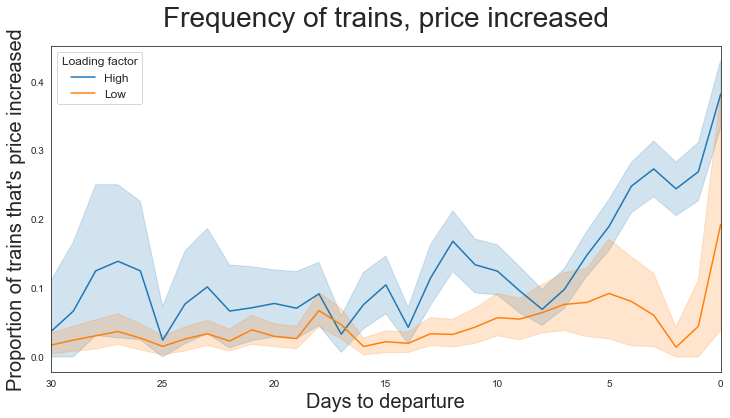

In [609]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(
    data=data,
    x="days_till_dep",
    y="price_increase",
    estimator="mean",
    hue="loading_factor_cat",
)
plt.gca().invert_xaxis()

ax.legend(("High", "Low"), loc="upper left", prop={"size": 12}).set_title(
    "Loading factor", prop={"size": 12}
)

ax.set_xlim(30,0)
plt.xlabel("Days to departure", fontsize=20, fontweight=450)
plt.ylabel("Proportion of trains that's price increased", fontsize=20, fontweight=450)


plt.title("Frequency of trains, price increased", fontsize=28, y=1.04)

plt.savefig("figures/price_change_loading_days", dpi=300)
plt.show()

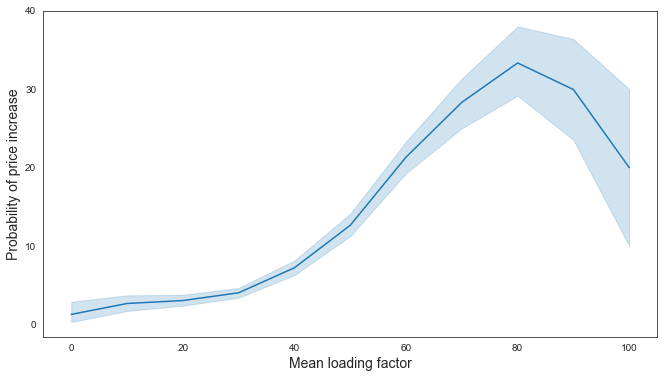

In [610]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(
    data=data,
    x="loading_factor_round",
    y="price_increase",
    estimator="mean",
    #hue="sales_prev_day",
)

# plt.gca().invert_xaxis()

plt.xlabel("Mean loading factor", fontsize=14, fontweight=450)
plt.ylabel("Probability of price increase", fontsize=14, fontweight=450)

tick_max = 0.4
tick_min = 0
tick_interval = 0.1

ax.set_yticks(np.arange(tick_min, tick_max + tick_interval, tick_interval))
ax.set_yticklabels(
    np.arange(int(tick_min * 100), int(tick_max * 100 + 1), int(tick_interval * 100))
)

tick_max = 1
tick_min = 0
tick_interval = 0.2

ax.set_xticks(np.arange(tick_min, tick_max + tick_interval, tick_interval))
ax.set_xticklabels(
    np.arange(int(tick_min * 100), int(tick_max * 100 + 1), int(tick_interval * 100))
)

# plt.title("Mean available seats evolution", fontsize=28, y=1.04)
plt.show()

___

# Statistical models

In [612]:
data = pd.read_pickle("data/MAD_BAR_small_trains_features.pkl")

In [110]:
import statsmodels.api as sm 

In [618]:
#ezeket benne van hogy ki kell baszni
data.loc[(data["days_till_dep"] < 5) & (data["capacity"] > 0.7),"train_id"].unique()

array(['BARCELONAMADRID2020-03-02 17:25:002020-03-02 19:55:00',
       'BARCELONAMADRID2020-03-07 12:00:002020-03-07 15:10:00',
       'BARCELONAMADRID2020-03-07 21:15:002020-03-08 00:02:00',
       'BARCELONAMADRID2020-03-13 06:25:002020-03-13 08:55:00',
       'BARCELONAMADRID2020-03-13 19:25:002020-03-13 21:55:00',
       'BARCELONAMADRID2020-03-14 16:00:002020-03-14 19:10:00',
       'BARCELONAMADRID2020-03-15 08:00:002020-03-15 11:10:00',
       'BARCELONAMADRID2020-03-16 06:25:002020-03-16 08:55:00',
       'BARCELONAMADRID2020-03-16 07:25:002020-03-16 10:01:00',
       'BARCELONAMADRID2020-03-16 13:25:002020-03-16 16:10:00',
       'BARCELONAMADRID2020-03-16 17:00:002020-03-16 19:45:00',
       'BARCELONAMADRID2020-03-16 18:00:002020-03-16 21:10:00',
       'BARCELONAMADRID2020-03-16 18:25:002020-03-16 20:55:00',
       'BARCELONAMADRID2020-03-16 19:25:002020-03-16 21:55:00',
       'BARCELONAMADRID2020-03-17 06:25:002020-03-17 08:55:00',
       'BARCELONAMADRID2020-03-17 06:40:

In [210]:
1,2,3,4,5,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27, 29

(1, 2, 3, 4, 5, 10, 11, 12, 13, 14, 15, 16, 17)

In [619]:
drop_trains = data.loc[(data["days_till_dep"] < 5) & (data["capacity"] > 0.7)]["train_id"].unique()

In [620]:
data = data.loc[~data["train_id"].isin(drop_trains)]

In [623]:
data["days_till_dep"] = data["days_till_dep"].astype("category")
data["weekday"] = data["weekday"].astype("category")

In [628]:
# utolsó 5 nap
log_reg = smf.logit(
    "price_increase ~ loading_factor",
    data=data.loc[data["days_till_dep"].isin(range(0, 5))],
).fit(cov_type='HC0')
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.574666
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         price_increase   No. Observations:                 2350
Model:                          Logit   Df Residuals:                     2348
Method:                           MLE   Df Model:                            1
Date:                Sat, 05 Dec 2020   Pseudo R-squ.:                 0.01651
Time:                        13:09:53   Log-Likelihood:                -1350.5
converged:                       True   LL-Null:                       -1373.1
Covariance Type:                  HC0   LLR p-value:                 1.652e-11
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.3128      0.191    -12.117      0.000      -2.687      -1.939
loading_factor     2.0358      0.283      7.189      0.000       1.481       2.591
==================================================================================
"""

In [631]:
# utolsó 5 nap
log_reg = smf.logit(
    "price_increase ~ loading_factor + weekday",
    data=data.loc[data["days_till_dep"].isin(range(0, 5))],
).fit(cov_type='HC0')
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.570120
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         price_increase   No. Observations:                 2350
Model:                          Logit   Df Residuals:                     2342
Method:                           MLE   Df Model:                            7
Date:                Sat, 05 Dec 2020   Pseudo R-squ.:                 0.02429
Time:                        13:10:37   Log-Likelihood:                -1339.8
converged:                       True   LL-Null:                       -1373.1
Covariance Type:                  HC0   LLR p-value:                 6.808e-12
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.4729      0.214    -11.551      0.000      -2.892      -2.053
weekday[T.1]       0.1898      0.145      1.305      0.192      -0.095       0.475
weekday[T.2]       0.1335      0.155      0.864      0.388      -0.169       0.436
weekday[T.3]      -0.3131      0.193     -1.622      0.105      -0.692       0.065
weekday[T.4]       0.4265      0.180      2.367      0.018       0.073       0.780
weekday[T.5]       0.3879      0.163      2.384      0.017       0.069       0.707
weekday[T.6]      -0.1711      0.201     -0.850      0.395      -0.566       0.223
loading_factor     2.1065      0.285      7.393      0.000       1.548       2.665
==================================================================================
"""

In [629]:
# 
log_reg = smf.logit(
    "price_increase ~ loading_factor",
    data=data.loc[data["days_till_dep"].isin(range(5, 10))],
).fit(cov_type='HC0')
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.350295
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         price_increase   No. Observations:                 2423
Model:                          Logit   Df Residuals:                     2421
Method:                           MLE   Df Model:                            1
Date:                Sat, 05 Dec 2020   Pseudo R-squ.:                 0.02148
Time:                        13:10:06   Log-Likelihood:                -848.76
converged:                       True   LL-Null:                       -867.39
Covariance Type:                  HC0   LLR p-value:                 1.036e-09
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.5139      0.246    -14.256      0.000      -3.997      -3.031
loading_factor     2.9477      0.460      6.411      0.000       2.047       3.849
==================================================================================
"""

In [630]:
log_reg = smf.logit(
    "price_increase ~ loading_factor + day_part * weekday",
    data=data.loc[data["days_till_dep"].isin(range(10, 15))],
).fit(cov_type="HC0")
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.235443
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         price_increase   No. Observations:                 2406
Model:                          Logit   Df Residuals:                     2391
Method:                           MLE   Df Model:                           14
Date:                Sat, 05 Dec 2020   Pseudo R-squ.:                  0.1316
Time:                        13:10:11   Log-Likelihood:                -566.48
converged:                       True   LL-Null:                       -652.29
Covariance Type:                  HC0   LLR p-value:                 3.208e-29
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -5.5029      0.448    -12.279      0.000      -6.381      -4.625
day_part[T.True]                  1.7569      0.386      4.552      0.000       1.000       2.513
weekday[T.1]                     -0.0449      0.526     -0.085      0.932      -1.076       0.986
weekday[T.2]                     -0.6989      0.681     -1.027      0.304      -2.033       0.635
weekday[T.3]                      0.3885      0.508      0.764      0.445      -0.608       1.385
weekday[T.4]                     -0.6826      0.689     -0.991      0.322      -2.032       0.667
weekday[T.5]                      0.1118      0.502      0.223      0.824      -0.872       1.095
weekday[T.6]                      0.8183      0.451      1.816      0.069      -0.065       1.701
day_part[T.True]:weekday[T.1]    -0.0165      0.578     -0.028      0.977      -1.149       1.117
day_part[T.True]:weekday[T.2]    -0.6852      0.792     -0.865      0.387      -2.238       0.867
day_part[T.True]:weekday[T.3]    -1.3847      0.684     -2.025      0.043      -2.725      -0.044
day_part[T.True]:weekday[T.4]    -0.6541      0.823     -0.795      0.427      -2.268       0.959
day_part[T.True]:weekday[T.5]    -1.7822      0.653     -2.729      0.006      -3.062      -0.502
day_part[T.True]:weekday[T.6]    -0.7901      0.613     -1.288      0.198      -1.992       0.412
loading_factor                    5.3069      0.691      7.682      0.000       3.953       6.661
=================================================================================================
"""

___

### innentől random modellek

In [ ]:
data = pd.concat(
    [
        data[["train_id", "departure"]],
        data[data.columns.difference(["train_id", "departure"])].astype("float"),
    ],
    axis=1,
)

In [ ]:
data_all = data.set_index(["train_id", "days_till_dep"])

In [ ]:
fe_lm = PanelOLS.from_formula(
    "ln_price ~ ln_econ_seat + TimeEffects + EntityEffects",
    data_all,
    drop_absorbed=True,
).fit(cov_type="clustered", cluster_entity=True)

In [ ]:
fe_lm.summary

In [ ]:
data_all = data

In [ ]:
data_all.loc[data_all["days_till_dep"] == 1].rename(
    columns={"ln_econ_seat": "ln_econ_seat_1"}
)[["train_id", "ln_econ_seat_1"]]

In [ ]:
i= 0

In [ ]:
data_try = data_all.loc[data_all["days_till_dep"] == i].merge(
    data_all.loc[data_all["days_till_dep"] == i+1].rename(
        columns={"ln_econ_seat": "ln_econ_seat_1"}
    )[["train_id", "ln_econ_seat_1"]],
    on="train_id",
)

In [ ]:
data.loc[:, "weekday"] = data.loc[:, "weekday"].astype("category")
data.loc[:, "depart_hour"] = data.loc[:, "depart_hour"].astype("category")

In [ ]:
model = smf.ols(
    formula="ln_price ~ ln_econ_seat  + duration + weekday + depart_hour",
    data=data,
)
OLS_reg = model.fit(
    cov_type="cluster",
    cov_kwds={"groups": data.loc[model.data.row_labels, "train_id"]},
)

In [ ]:
OLS_reg.summary()

In [ ]:
data.loc[:, "days_till_dep"] = data.loc[:, "days_till_dep"].astype("category")
data.loc[:, "weekday"] = data.loc[:, "weekday"].astype("category")
data.loc[:, "depart_hour"] = data.loc[:, "depart_hour"].astype("category")
IV_reg = IVGMM(
    data["ln_price"],
    data[["const", "days_till_dep", "duration"]],
    data["ln_econ_seat"],
    data[["weekday", "depart_hour"]],
).fit(
    cov_type="kernel",
    # cov_kwds={"groups": data.loc[model.data.row_labels, "train_id"]},
)
IV_reg.summary

In [ ]:
data = pd.read_pickle("data/MAD_BAR_features_v2.pkl")

data["price_change"] = data.groupby("train_id")["mean_price"].transform("diff")

train_ids = (
    data.groupby("train_id")["price_change"]
    .max()
    .reset_index()
    .sort_values(by=["price_change"])
    .reset_index(drop=True)
    .loc[:105, "train_id"]
    .values
)
data = data.loc[data["train_id"].isin(train_ids)]

data["days_till_dep"] = data["days_till_dep"].astype(int)
data = data.loc[data["days_till_dep"] < 15].reset_index(drop=True)

data.loc[:, "days_till_dep"] = data.loc[:, "days_till_dep"].astype("category")
data.loc[:, "weekday"] = data.loc[:, "weekday"].astype("category")
data.loc[:, "depart_hour"] = data.loc[:, "depart_hour"].astype("category")
IV_reg = IVGMM(
    data["ln_price"],
    data[["const", "days_till_dep", "duration"]],
    data["ln_econ_seat"],
    data[["weekday", "depart_hour"]],
).fit(
    cov_type="kernel",
    # cov_kwds={"groups": data.loc[model.data.row_labels, "train_id"]},
)
IV_reg.summary

In [ ]:
sns.lineplot(data=pd.DataFrame(IV_reg.params.iloc[1:-2]).reset_index())
plt.gca().invert_xaxis()

In [ ]:
data_all = data_all.reset_index()

In [ ]:
dic_estimate = {}
dic_confidence = {}
for i in range(0, 30):
    data = data_all.loc[data_all["days_till_dep"] == i].merge(
        data_all.loc[data_all["days_till_dep"] == i + 1].rename(
            columns={"ln_econ_seat": "ln_econ_seat_1"}
        )[["train_id", "ln_econ_seat_1"]],
        on="train_id",
    )
    data.loc[:, "weekday"] = data.loc[:, "weekday"].astype("category")
    data.loc[:, "depart_hour"] = data.loc[:, "depart_hour"].astype("category")

    IV_reg = IVGMM(
        data["ln_price"],
        data[["const", "duration"]],
        data["ln_econ_seat"],
        data[["weekday", "depart_hour"]],
    ).fit()

    dic_estimate[i] = IV_reg.params["ln_econ_seat"]
    dic_confidence[i] = IV_reg.conf_int().loc["ln_econ_seat"].values

In [ ]:
estimates = pd.concat(
    [
        pd.DataFrame(dic_confidence).T.rename(columns={0: "lower", 1: "upper"}),
        pd.DataFrame(dic_estimate.values()).rename(columns={0: "estimate"}),
    ],
    axis=1,
).reset_index()

estimates = estimates.loc[0:30, :]
estimates["x"] = 0
plt.plot("index", "estimate", data=estimates, color="blue", linewidth=2)
plt.plot(
    "index", "lower", data=estimates, color="blue", linewidth=1, linestyle="dashed"
)
plt.plot(
    "index", "upper", data=estimates, color="blue", linewidth=1, linestyle="dashed"
)
plt.plot("index", "x", data=estimates, color="black", linewidth=1.5)

In [ ]:
 ln_econ_seat.shift(1) + ln_econ_seat.shift(2)

In [ ]:
dic_estimate = {}
dic_confidence = {}

for i in range(0, 30):
    data = data_all.loc[data_all["days_till_dep"] == i].merge(
        data_all.loc[data_all["days_till_dep"] == i + 1].rename(
            columns={"ln_econ_seat": "ln_econ_seat_1"}
        )[["train_id", "ln_econ_seat_1"]],
        on="train_id",
    )
    data.loc[:, "weekday"] = data.loc[:, "weekday"].astype("category")
    data.loc[:, "depart_hour"] = data.loc[:, "depart_hour"].astype("category")

    model = smf.ols(
        formula="ln_price ~ ln_econ_seat + ln_econ_seat_1 + duration + weekday + depart_hour",
        data=data,
    )
    OLS_reg = model.fit(
        cov_type="cluster",
        cov_kwds={"groups": data.loc[model.data.row_labels, "train_id"]},
    )

    variable = "ln_econ_seat"

    dic_estimate[i] = OLS_reg.params[variable]
    dic_confidence[i] = OLS_reg.conf_int().loc[variable].values

In [ ]:
estimates = pd.concat(
    [
        pd.DataFrame(dic_confidence).T.rename(columns={0: "lower", 1: "upper"}),
        pd.DataFrame(dic_estimate.values()).rename(columns={0: "estimate"}),
    ],
    axis=1,
).reset_index()

estimates = estimates.loc[0:20, :]
estimates["x"] = 0
plt.plot("index", "estimate", data=estimates, color="blue", linewidth=2)
plt.plot(
    "index", "lower", data=estimates, color="blue", linewidth=1, linestyle="dashed"
)
plt.plot(
    "index", "upper", data=estimates, color="blue", linewidth=1, linestyle="dashed"
)
plt.plot("index","x", data=estimates, color="black", linewidth=1.5)